In [1]:
# Installing the CPPE-5 package 
!pip install cppe5

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.2.2-py3-none-any.whl size=14495 sha256=cdd70b27ccb03cabf4c01910c89f6e0b2530ce268e66e48f6edfc0dcfe15427b
  Stored in directory: /root/.cache/pip/wheels/a3/53/90/1645445c55828e0123d2d8ef01373697684ab621c917dd480b
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


# Accesing data from google drive , since it is problematic to upload the whole dataset at every runtime in google collab. 
# Making a folder in google drive and linking it here with code makes it easy to access. Although, we have to give permission everytime, which is pretty easy 

# Here, i have made a folder "data" in the my google drive and have placed my images and annotations in that folder. PFA the screenshot below of the folder structure


<img src='https://drive.google.com/uc?id=1IY8udOiOgdgjkWyxNrSxcJbiNYsFp_Lg'>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
print(os.getcwd())
os.chdir('/content/drive/MyDrive')

/content


In [4]:
print(os.getcwd())

/content/drive/MyDrive


In [5]:
!pip install --upgrade torchvision

In [6]:
print(os.getcwd())
import os
import cppe5
from cppe5.torch import data_loader
import torch
import matplotlib.pyplot as plt
import torchvision

from PIL import Image
import torchvision.transforms as transforms
import numpy as np

data_loader = cppe5.torch.data_loader() # torch.utils.data.DataLoader
print(data_loader)

/content/drive/MyDrive
loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


In [7]:
# Get the GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [8]:
!nvidia-smi

Fri May  6 05:52:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## In case you want to use Faster-RCNN model with Resnet-50 model 
## Please uncomment the below code in next cell and comment the code in next to next cell

In [ ]:
# def get_model_instance_segmentation(num_classes): 
#     # model 1
#     model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     model.roi_heads.box_predictor = (
#         torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
#             in_features, num_classes
#         )
#     )
    
#     return model

In [ ]:
## In case you want to use Faster-RCNN model with Mobilenet model 
## Please uncomment the below code in next cell and comment the code in previous cell 

In [11]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

# Defining number of classes 

In [12]:
num_classes = 5

In [13]:
# move model to the right device
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

In [ ]:
loss_plot = []
count = []
epoch_loss = 0
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    image_count = 0
    average_loss = 0
    loc_count = 0
    print(" Epoch count : "+str(epoch))
    for imgs, annotations in data_loader: 
      imgs = list(img.to(device) for img in imgs)
      annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
      image_count += 1
      if(image_count == 100):
        break;
      if(image_count % 100 == 0):
        print(image_count)
      try:
        loss_dict = model(imgs, annotations)
        #print(loss_dict)
        sum_loss = 0
        for loss in loss_dict.values():
          sum_loss += loss
        losses = sum_loss
        average_loss += losses
        loc_count += 1
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
      except RuntimeError:
        print("")
    epoch_loss = average_loss/loc_count;
    loss_plot.append(epoch_loss)
    count.append(epoch)
    print(f"epoch: {epoch}/{num_epochs}, Loss: {epoch_loss}")

 Epoch count : 0




epoch: 0/100, Loss: 0.5621883273124695
 Epoch count : 1

epoch: 1/100, Loss: 0.8406716585159302
 Epoch count : 2

epoch: 2/100, Loss: 0.5195844769477844
 Epoch count : 3



epoch: 3/100, Loss: 0.6648622155189514
 Epoch count : 4





epoch: 4/100, Loss: 0.5250364542007446
 Epoch count : 5






epoch: 5/100, Loss: 0.5835452079772949
 Epoch count : 6


epoch: 6/100, Loss: 0.7738067507743835
 Epoch count : 7




epoch: 7/100, Loss: 0.48052576184272766
 Epoch count : 8


epoch: 8/100, Loss: 0.5596948266029358
 Epoch count : 9


epoch: 9/100, Loss: 0.5364624857902527
 Epoch count : 10




epoch: 10/100, Loss: 0.6069017052650452
 Epoch count : 11


epoch: 11/100, Loss: 0.4861202538013458
 Epoch count : 12



epoch: 12/100, Loss: 0.47871363162994385
 Epoch count : 13




epoch: 13/100, Loss: 0.4857947826385498
 Epoch count : 14







epoch: 14/100, Loss: 0.47582775354385376
 Epoch count : 15

epoch: 15/100, Loss: 0.45345547795295715
 Epoch count : 16


epoch: 16/100, Lo

In [18]:
loss_plot_2 = []
loss_plot_orig = []
for i in range(len(loss_plot)):
  loss_plot_orig.append(loss_plot[i].item())

sum = 0;
for i in range(len(loss_plot)):
  sum += loss_plot[i].item()
  loss_plot_2.append(sum/(i+1))


Text(0.5, 0, 'Number of Epochs')

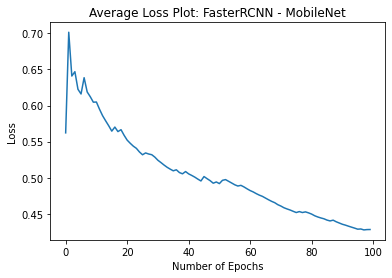

In [19]:
plt.plot(count,loss_plot_2)
plt.title('Average Loss Plot: FasterRCNN - MobileNet')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')